In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['LANL-Earthquake-Prediction', 'important-features']


In [2]:
# Import train and test with features importance
train = pd.read_csv('../input/important-features/train_features.csv')
test = pd.read_csv('../input/important-features/test_features.csv')
y = pd.read_csv('../input/important-features/y_train.csv')

lasso_importance = pd.read_csv('../input/important-features/lasso_importance.csv')
lgb_importance = pd.read_csv('../input/important-features/lgb_importance.csv')
xgb_importance = pd.read_csv('../input/important-features/xgb_importance.csv')

In [3]:
lgb_importance.head()

,Hann_window_mean,1.36
0,Hilbert_mean,11.92
1,Imag_max,30.36
2,Imag_mean,112.52
3,Imag_min,17.72
4,Imag_std,4.76


In [4]:
xgb_importance.head()

,Hann_window_mean,2.8247137e-05
0,Hilbert_mean,0.001065
1,Imag_max,0.000608
2,Imag_mean,0.000455
3,Imag_min,0.000000
4,Imag_std,0.000406


> Get the top 15 important features

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = lgb_importance[lgb_importance.columns[1]].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(x) 
lgb_importance_n = pd.DataFrame(scaled_values , index = [lgb_importance[lgb_importance.columns[0]]], columns = ["scaled_values"])

x = xgb_importance[xgb_importance.columns[1]].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(x) 
xgb_importance_n = pd.DataFrame(scaled_values , index = [xgb_importance[xgb_importance.columns[0]]], columns = ["scaled_values"])

x = lasso_importance[lasso_importance.columns[1]].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(x) 
lasso_importance_n = pd.DataFrame(scaled_values , index = [lasso_importance[lasso_importance.columns[0]]], columns = ["scaled_values"])

added_importance = lgb_importance_n.add(xgb_importance_n, axis = 1)
added_importance.nlargest(15,"scaled_values").head()

,scaled_values
Hann_window_mean,
q05_roll_std_10,2.000000
q05_roll_std_100,1.857555
q05_roll_std_1000,0.990242
number_peaks,0.610652
min_roll_std_100,0.568270


In [6]:
added_importance = added_importance.add(lasso_importance_n, axis = 1)
added_importance.nlargest(15,"scaled_values").head()

,scaled_values
Hann_window_mean,
q05_roll_std_10,2.068534
q05_roll_std_100,1.857555
number_peaks,1.610652
q05_roll_std_1000,1.377802
mean_change_rate_first_50000,1.146572


In [7]:
important15 = added_importance.nlargest(15,"scaled_values")
tuple_important = important15.index.get_values()
tuple_important

array([('q05_roll_std_10',), ('q05_roll_std_100',), ('number_peaks',),
       ('q05_roll_std_1000',), ('mean_change_rate_first_50000',),
       ('Imag_mean',), ('skew',), ('mean_change_rate_last_50000',),
       ('av_change_abs_roll_mean_10',), ('av_change_abs_roll_std_100',),
       ('autocorrelation_30000',), ('min_roll_std_100',),
       ('min_roll_std_10',), ('autocorrelation_60000',), ('abs_energy',)],
      dtype=object)

In [8]:
# Transform from tuple to list 
list_important = []
for item in tuple_important:
    list_important.append(item[0])

In [9]:
# Extract most important features in Train and Test 
    
train_important = train[list_important]
test_important = test[list_important]

train_important.head()

,q05_roll_std_10,q05_roll_std_100,number_peaks,q05_roll_std_1000,mean_change_rate_first_50000,Imag_mean,skew,mean_change_rate_last_50000,av_change_abs_roll_mean_10,av_change_abs_roll_std_100,autocorrelation_30000,min_roll_std_100,min_roll_std_10,autocorrelation_60000,abs_energy
0,0.050334,0.138030,-0.393871,0.184599,-0.256857,-0.458570,-0.313703,0.209982,-0.301212,-0.125616,-0.754308,-0.146396,-1.114878,0.436078,0.526427
1,0.204169,0.141753,-0.535372,-0.151082,-0.177769,0.286705,0.553891,0.316524,0.085288,-0.015101,1.136826,0.579812,-1.114878,0.518231,1.638030
2,0.810249,0.856220,-0.863397,0.769589,-0.077300,-0.540244,0.191534,-0.020308,-0.153974,0.121662,0.272212,0.295466,0.216210,1.245913,0.701400
3,0.255237,0.375361,-0.548236,0.296334,0.193475,-0.417733,1.321245,0.726007,0.214121,-0.205746,-0.612602,0.112068,0.216210,1.084538,-1.114674
4,0.204169,0.319221,-0.898772,0.319527,0.564525,0.113148,-0.128324,0.473352,-0.264403,0.031992,-0.161605,0.446803,0.216210,0.297338,0.531109


In [10]:
y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


> ## Catboost using most important Features 

In [11]:
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

Train catboost

In [12]:
%%time
train_pool = Pool(train_important, y)
cat_model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
cat_model.fit(train_important, y, plot=True, silent = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 7min 36s, sys: 1min, total: 8min 36s
Wall time: 3min 8s


In [13]:
y_pred_cat = cat_model.predict(test_important)
y_train_cat = cat_model.predict(train_important)

In [14]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y,y_train_cat)

1.5207420738310171

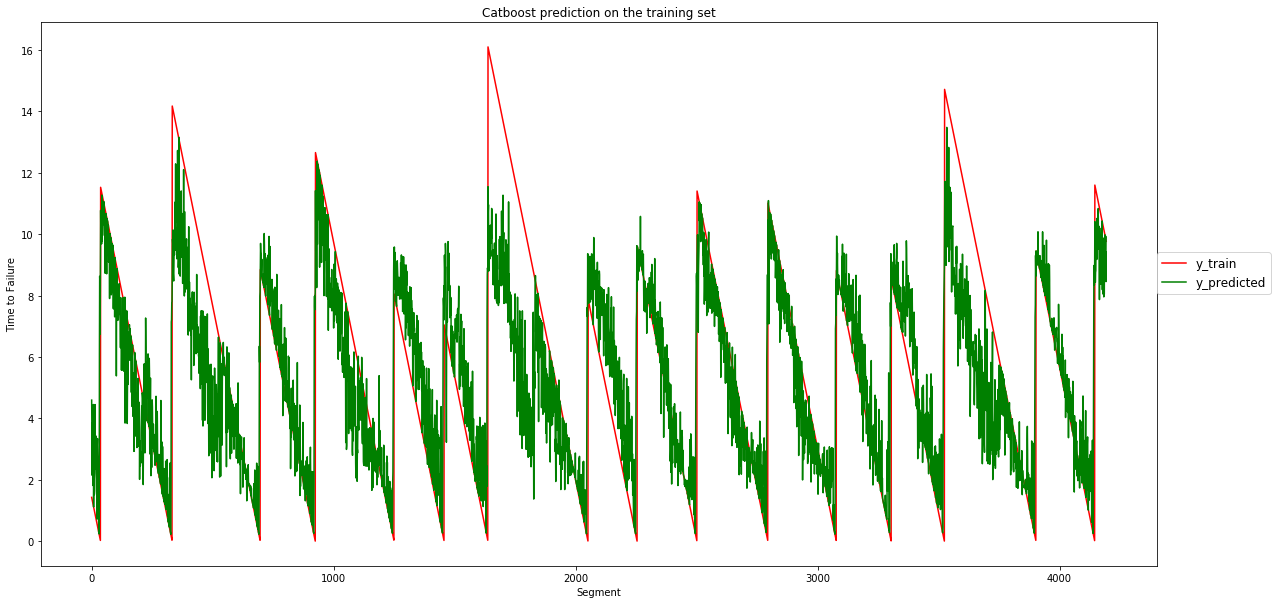

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(y, color='r', label='y_train')
plt.plot(y_train_cat, color='g', label='y_predicted')
plt.xlabel("Segment")
plt.ylabel("Time to Failure")
plt.legend(loc=(1, 0.5), fontsize = 'large');
plt.title('Catboost prediction on the training set');

In [16]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = y_pred_cat
submission.to_csv('submission_cat_important.csv')

> ## SVR using most important Features 

In [17]:
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.25, 0.5, 1, 1.5, 2, 2.5, 3.0]}]

reg = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg.fit(train_important, y.values.flatten())

print("Best CV score: {:.4f}".format(reg.best_score_))
print(reg.best_params_)

Best CV score: -2.1250
{'C': 1, 'gamma': 0.005}


In [18]:
y_pred_svr = reg.predict(test_important)
y_train_svr = reg.predict(train_important)

In [19]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y,y_train_svr)

2.057466306148281

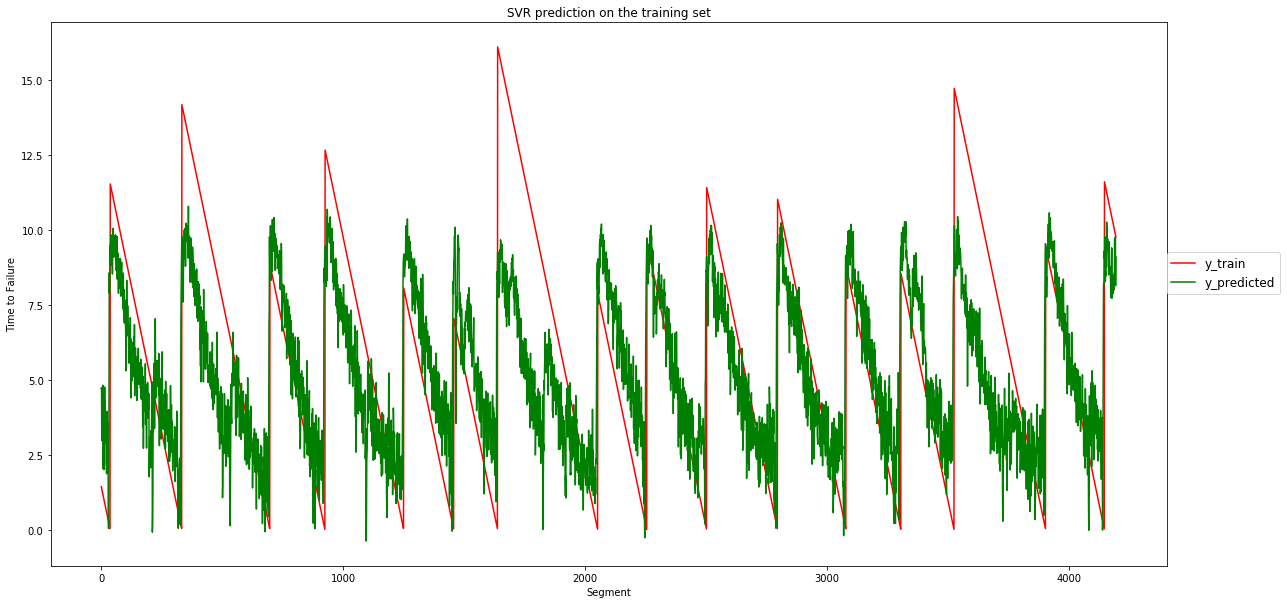

In [20]:
plt.figure(figsize=(20,10))
plt.plot(y, color='r', label='y_train')
plt.plot(y_train_svr, color='g', label='y_predicted')
plt.xlabel("Segment")
plt.ylabel("Time to Failure")
plt.legend(loc=(1, 0.5), fontsize = 'large');
plt.title('SVR prediction on the training set');

In [21]:
submission['time_to_failure'] = y_pred_svr
submission.to_csv('submission_SVR_important.csv')